### dataset\dataset.ipynb 에서 train, test 데이터 전처리

### 필요한 함수 헤더 include

```c
#define _CRT_SECURE_NO_WARNINGS
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
```

# 신경망에서 필요한 함수 정의
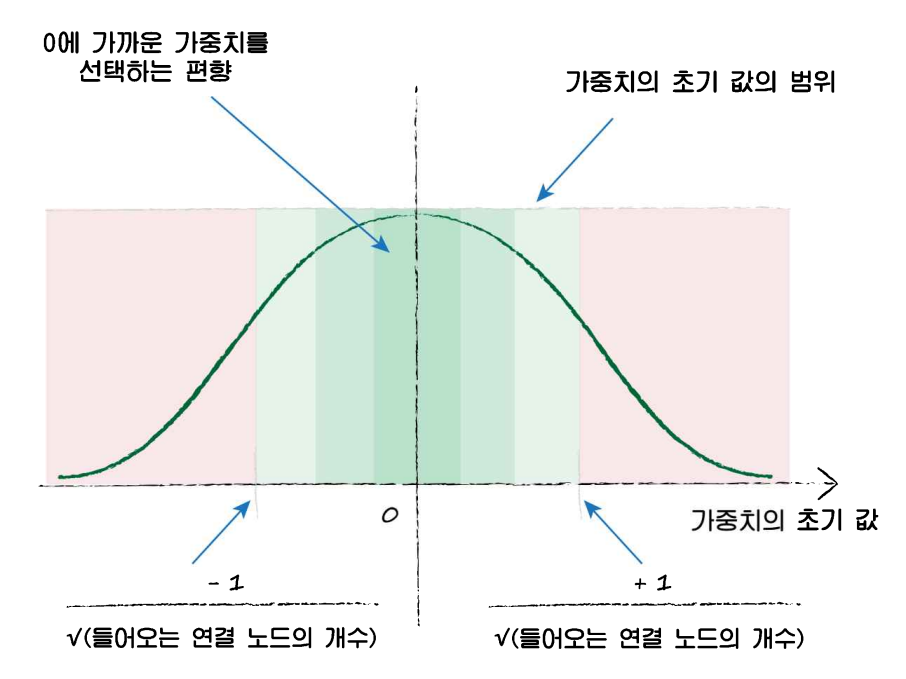

```c
// 가중치 행렬 초기화 함수
double** initialize_weights(int inputnodes, int outputnodes) {
    double** weights = (double**)malloc(outputnodes * sizeof(double*));
    for (int i = 0; i < outputnodes; i++) {
        weights[i] = (double*)malloc(inputnodes * sizeof(double));
        for (int j = 0; j < inputnodes; j++) {
            weights[i][j] = (double)rand() / RAND_MAX - 0.5;
        }
    }
    return weights;
}

// 시그모이드 함수
double sigmoid(double x) {
    return 1.0 / (1.0 + exp(-x));
}

// 활성화 함수
// 행렬의 각 요소에 시그모이드 함수 적용
double** activation_function(double** a, int rows, int cols) {
    double** result = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        result[i] = (double*)malloc(cols * sizeof(double));
        for (int j = 0; j < cols; j++) {
            result[i][j] = sigmoid(a[i][j]);
        }
    }
    return result;
}
```

# 행렬 계산 함수 정의

```c
// 1차원 배열을 2차원 행렬로 변환
double** convert_to_matrix(double* a, int rows) {
    double** result = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        result[i] = (double*)malloc(sizeof(double));
        result[i][0] = a[i];
    }
    return result;
}

// 행렬+행렬 계산 함수
double** matrix_add(double** a, double** b, int rows, int cols) {
    double** result = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        result[i] = (double*)malloc(cols * sizeof(double));
        for (int j = 0; j < cols; j++) {
            result[i][j] = a[i][j] + b[i][j];
        }
    }
    return result;
}

// 행렬-행렬 계산 함수
double** matrix_sub(double** a, double** b, int rows, int cols) {
    double** result = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        result[i] = (double*)malloc(cols * sizeof(double));
        for (int j = 0; j < cols; j++) {
            result[i][j] = a[i][j] - b[i][j];
        }
    }
    return result;
}

// 행렬*행렬 계산 함수
double** matrix_mul(double** a, double** b, int rows, int cols) {
    double** result = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        result[i] = (double*)malloc(cols * sizeof(double));
        for (int j = 0; j < cols; j++) {
            result[i][j] = a[i][j] * b[i][j];
        }
    }
    return result;
}

// 행렬곱 계산 함수
double** matrix_dot(double** a, double** b, int rows_a, int cols_a, int cols_b) {
    // cols_a = rows_b
    double** result = (double**)malloc(rows_a * sizeof(double*));
    for (int i = 0; i < rows_a; i++) {
        result[i] = (double*)malloc(cols_b * sizeof(double));
        for (int j = 0; j < cols_b; j++) {
            result[i][j] = 0;
            for (int k = 0; k < cols_a; k++) {
                result[i][j] = result[i][j] + (a[i][k] * b[k][j]);
            }
        }
    }
    return result;
}

// 스칼라-행렬 계산 함수
double** scalar_matrix_sub(double s, double** a, int rows, int cols) {
    double** result = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        result[i] = (double*)malloc(cols * sizeof(double));
        for (int j = 0; j < cols; j++) {
            result[i][j] = s - a[i][j];
        }
    }
    return result;
}

// 스칼라*행렬 계산 함수
double** scalar_matrix_mul(double s, double** a, int rows, int cols) {
    double** result = (double**)malloc(rows * sizeof(double*));
    for (int i = 0; i < rows; i++) {
        result[i] = (double*)malloc(cols * sizeof(double));
        for (int j = 0; j < cols; j++) {
            result[i][j] = s * a[i][j];
        }
    }
    return result;
}

// 행렬 전치 함수
double** matrix_transpose(double** a, int rows, int cols) {
    double** result = (double**)malloc(cols * sizeof(double*));
    for (int i = 0; i < cols; i++) {
        result[i] = (double*)malloc(rows * sizeof(double));
        for (int j = 0; j < rows; j++) {
            result[i][j] = a[j][i];
        }
    }
    return result;
}
```

# 신경망 구조체 정의, 신경망 초기화 함수, 신경망 학습 함수, 신경망 테스트 함수 작성
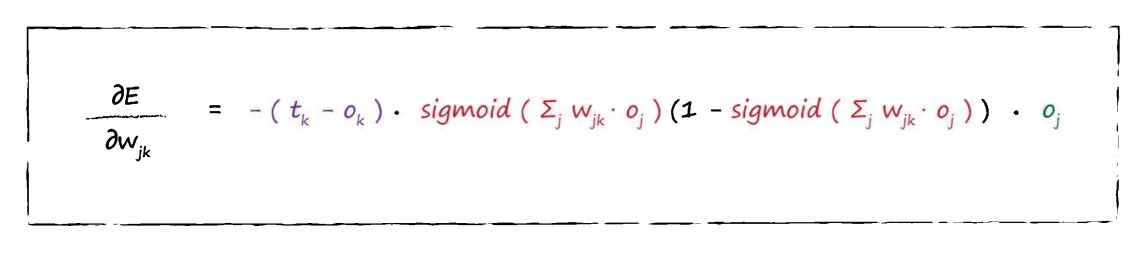
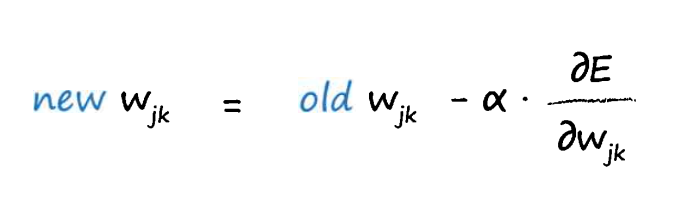

```c
// 신경망 구조체 정의
typedef struct {
    int inodes;
    int hnodes;
    int onodes;
    double** wih;
    double** who;
    double lr;
} NeuralNetwork;

// 신경망 초기화 함수
NeuralNetwork* initialize_neural_network(int inputnodes, int hiddennodes, int outputnodes, double learningrate) {
    NeuralNetwork* nn = (NeuralNetwork*)malloc(sizeof(NeuralNetwork));
    nn->inodes = inputnodes;
    nn->hnodes = hiddennodes;
    nn->onodes = outputnodes;
    nn->wih = initialize_weights(inputnodes, hiddennodes);  // rows=hnodes, cols=inodes
    nn->who = initialize_weights(hiddennodes, outputnodes); // rows=onodes, cols=hnodes
    nn->lr = learningrate;
    return nn;
}

// 신경망 학습 함수
void train(NeuralNetwork* nn, double* inputs_list, double* targets_list) {
    // 입력 리스트, target 리스트를 2차원의 행렬로 변환
    double** inputs = convert_to_matrix(inputs_list, nn->inodes);   // rows=inodes, cols=1
    double** targets = convert_to_matrix(targets_list, nn->onodes); // rows=onodes, cols=1
    
    // 은닉 계층으로 들어오는 신호 계산
    double** hidden_inputs = matrix_dot(nn->wih, inputs, nn->hnodes, nn->inodes, 1); // row는 hnodes, cols는 1
    // 은닉 계층에서 나가는 신호 계산
    double** hidden_outputs = activation_function(hidden_inputs, nn->hnodes, 1); // rows=hnodes, cols=1
    // 출력 계층으로 들어오는 신호 계산
    double** final_inputs = matrix_dot(nn->who, hidden_outputs, nn->onodes, nn->hnodes, 1); // rows=onodes, cols=1
    // 출력 계층에서 나가는 신호 계산
    double** final_outputs = activation_function(final_inputs, nn->onodes, 1); // rows=onodes, cols=1
    // 출력 계층의 오차 계산
    double** output_errors = matrix_sub(targets, final_outputs, nn->onodes, 1); // rows=onodes, cols=1
    // 은닉 계층의 오차 계산
    double** transposed_who = matrix_transpose(nn->who, nn->onodes, nn->hnodes); // rows=hnodes, cols=onodes
    double** hidden_errors = matrix_dot(transposed_who, output_errors, nn->hnodes, nn->onodes, 1); // rows=hnodes, cols=1   // 지금 여기 문제
    // 은닉 계층과 출력 계층 간의 가중치 행렬 업데이트
    // 파이썬 : self.who = matrix_add(self.who, scalar_matrix_mul(self.lr, matrix_dot((matrix_mul(matrix_mul(output_errors, final_outputs), scalar_matrix_sub(1, final_outputs))), matrix_transpose(hidden_outputs))))
    double** tmp15 = matrix_mul(output_errors, final_outputs, nn->onodes, 1); // rows=onodes, cols=1
    double** tmp16 = scalar_matrix_sub(1, final_outputs, nn->onodes, 1); // rows=onodes, cols=1
    double** tmp13 = matrix_mul(tmp15, tmp16, nn->onodes, 1); // rows=onodes, cols=1
    double** tmp14 = matrix_transpose(hidden_outputs, nn->hnodes, 1); // rows=1, cols=hnodes
    double** tmp12 = matrix_dot(tmp13, tmp14, nn->onodes, 1, nn->hnodes);   // rows=onodes, cols=hnodes
    double** tmp11 = scalar_matrix_mul(nn->lr, tmp12, nn->onodes, nn->hnodes); // rows=onodes, cols=hnodes
    double** old_who = nn->who;  // rows=onodes, cols=hnodes
    nn->who = matrix_add(old_who, tmp11, nn->onodes, nn->hnodes);
    // 입력 계층과 출력 계층 간의 가중치 행렬 업데이트
    // 파이썬 : self.wih = matrix_add(self.wih, scalar_matrix_mul(self.lr, matrix_dot((matrix_mul(matrix_mul(hidden_errors, hidden_outputs), scalar_matrix_sub(1, hidden_outputs))), matrix_transpose(inputs))))
    double** tmp25 = matrix_mul(hidden_errors, hidden_outputs, nn->hnodes, 1); // rows=hnodes, cols=1
    double** tmp26 = scalar_matrix_sub(1, hidden_outputs, nn->hnodes, 1); // rows=hnodes, cols=1
    double** tmp23 = matrix_mul(tmp25, tmp26, nn->hnodes, 1); // rows=hnodes, cols=1
    double** tmp24 = matrix_transpose(inputs, nn->inodes, 1); // rows=1, cols=inodes
    double** tmp22 = matrix_dot(tmp23, tmp24, nn->hnodes, 1, nn->inodes);   // rows=hnodes, cols=inodes
    double** tmp21 = scalar_matrix_mul(nn->lr, tmp22, nn->hnodes, nn->inodes); // rows=hnodes, cols=inodes
    double** old_wih = nn->wih;  // rows=hnodes cols=indoes
    nn->wih = matrix_add(old_wih, tmp21, nn->hnodes, nn->inodes);
    // free
    for (int i = 0; i < nn->inodes; i++) {
        free(inputs[i]);
    }
    free(inputs);
    for (int i = 0; i < nn->hnodes; i++) {
        free(hidden_inputs[i]);
        free(hidden_outputs[i]);
        free(transposed_who[i]);
        free(hidden_errors[i]);
        free(tmp25[i]); free(tmp26[i]); free(tmp23[i]); free(tmp22[i]); free(tmp21[i]);
        free(old_wih[i]);
    }
    free(hidden_inputs);
    free(hidden_outputs);
    free(transposed_who);
    free(hidden_errors);
    free(tmp25); free(tmp26); free(tmp23); free(tmp22); free(tmp21);
    free(old_wih);
    for (int i = 0; i < nn->onodes; i++) {
        free(targets[i]);
        free(final_inputs[i]);
        free(final_outputs[i]);
        free(output_errors[i]);
        free(tmp15[i]); free(tmp16[i]); free(tmp13[i]); free(tmp12[i]); free(tmp11[i]);
        free(old_who[i]);
    }
    free(targets);
    free(final_inputs);
    free(final_outputs);
    free(output_errors);
    free(tmp15); free(tmp16); free(tmp13); free(tmp12); free(tmp11);
    free(old_who);

    free(tmp14[0]); free(tmp24[0]);
    free(tmp14); free(tmp24);
}

// 신경망 테스트 함수
double** query(NeuralNetwork* nn, double* inputs_list) {
    // 입력 리스트를 2차원 행렬로 변환
    double** inputs = convert_to_matrix(inputs_list, nn->inodes);   // rows=inodes, cols=1
    // 은닉 계층으로 들어오는 신호 계산
    double** hidden_inputs = matrix_dot(nn->wih, inputs, nn->hnodes, nn->inodes, 1); // row는 hnodes, cols는 1
    // 은닉 계층에서 나가는 신호 계산
    double** hidden_outputs = activation_function(hidden_inputs, nn->hnodes, 1); // rows=hnodes, cols=1
    // 출력 계층으로 들어오는 신호 계산
    double** final_inputs = matrix_dot(nn->who, hidden_outputs, nn->onodes, nn->hnodes, 1); // rows=onodes, cols=1
    // 출력 계층에서 나가는 신호 계산
    double** final_outputs = activation_function(final_inputs, nn->onodes, 1); // rows=onodes, cols=1
    // free
    for (int i = 0; i < nn->inodes; i++) {
        free(inputs[i]);
    }
    free(inputs);
    for (int i = 0; i < nn->hnodes; i++) {
        free(hidden_inputs[i]);
        free(hidden_outputs[i]);
    }
    free(hidden_inputs);
    free(hidden_outputs);
    for (int i = 0; i < nn->onodes; i++) {
        free(final_inputs[i]);
    }
    free(final_inputs);
    return final_outputs;
}
```

# (MNIST) 신경망 선언, 학습 데이터 로드, 신경망 학습, 테스트 데이터 로드, 신경망 테스트, 결과 출력

```c
void MNIST() {
    // ============================== MNIST ==============================

    // 입력, 은닉, 출력 노드의 수
    int input_nodes = 28 * 28;
    int hidden_nodes = 200;
    int output_nodes = 10;
    // 학습률
    double learning_rate = 0.1;
    // 신경망 초기화
    NeuralNetwork* nn = initialize_neural_network(input_nodes, hidden_nodes, output_nodes, learning_rate);


    // MNIST 신경망 학습 하기
    FILE* train_data_file = fopen("mnist_train.csv", "r");
    if (train_data_file == NULL) {
        perror("Error opening file");
        return;
    }
    char line[28 * 28 * 5]; // 충분한 크기의 배열 할당
    int epochs = 1;
    printf("MNIST TRAIN\n");
    for (int epoch = 0; epoch < epochs; epoch++) {
        printf("epoch %d / %d\n", epoch + 1, epochs);
        int line_n = 0;
        // 파일에서 한 줄씩 읽어서 학습 수행
        while (fgets(line, sizeof(line), train_data_file) != NULL) {
            if (line_n == 1000) { break; }
            line_n += 1;
            // label 만들기
            int label = line[0] - '0';
            // targets 만들기
            double targets[10];
            for (int i = 0; i < 10; i++) {
                if (i == label) { targets[i] = 0.99; }
                else { targets[i] = 0.01; }
            }
            // ipnuts 만들기
            char* token = strtok(line + 2, ",");   // 라벨과 , 두 칸을 넘어감
            double inputs[28 * 28];
            for (int i = 0; i < 28 * 28; i++) {
                double value = atoi(token);
                inputs[i] = (value / 255 * 0.99) + 0.01;
                token = strtok(NULL, ",");
            }
            free(token);
            // train 수행
            train(nn, inputs, targets);
        }
        // 파일 포인터를 처음으로 되돌리기 (epoch을 다시 수행하기 위함)
        fseek(train_data_file, 0, SEEK_SET);
    }
    // 파일 닫기
    fclose(train_data_file);


    // MNIST 신경망 테스트 하기
    FILE* test_data_file = fopen("mnist_test.csv", "r");
    if (test_data_file == NULL) {
        perror("Error opening file");
        return;
    }
    char test_line[28 * 28 * 5];  // 충분한 크기의 배열 할당
    int correct = 0;
    int total = 0;
    // 파일에서 한 줄씩 읽어서 테스트 수행
    printf("MNIST TEST\nlabel\tanswer\n");
    int test_line_n = 0;
    while (fgets(test_line, sizeof(test_line), test_data_file) != NULL) {
        if (test_line_n == 20) { break; }
        test_line_n += 1;
        // label 만들기
        int label = test_line[0] - '0';
        // ipnuts 만들기
        char* token = strtok(test_line + 2, ",");   // 라벨과 , 두 칸을 넘어감
        double inputs[28 * 28];
        for (int i = 0; i < 28 * 28; i++) {
            double value = atoi(token);
            inputs[i] = (value / 255 * 0.99) + 0.01;
            token = strtok(NULL, ",");
        }
        free(token);
        // query 수행
        double** outputs = query(nn, inputs);
        // 정답 확인
        int answer = 0;
        double tmp = 0;
        for (int i = 0;i < 10;i++) {
            if (outputs[i][0] > tmp) { answer = i; tmp = outputs[i][0]; }
            free(outputs[i]);
        }
        free(outputs);
        printf("%d\t%d\n", label, answer);
        if (label == answer) { correct += 1; }
        total += 1;
    }
    // 파일 닫기
    fclose(test_data_file);


    // 정확도 출력
    printf("correct / total : %d / %d\n", correct, total);

    // free
    for (int i = 0; i < nn->onodes; i++) { free(nn->who[i]); }
    free(nn->who);
    for (int i = 0; i < nn->hnodes; i++) { free(nn->wih[i]); }
    free(nn->wih);
    free(nn);
}
```

### 결과는 아래와 같다

```
MNIST TRAIN
epoch 1 / 1
MNIST TEST
label   answer
7       7
2       5
1       1
0       0
4       4
1       1
4       3
9       4
5       6
9       7
0       0
6       2
9       9
0       0
1       1
5       5
9       7
7       7
3       3
4       4
correct / total : 13 / 20
```

# (손글씨) 신경망 선언, 학습 데이터 로드, 신경망 학습, 테스트 데이터 로드, 신경망 테스트, 결과 출력

```c
void handwrite() {
    // ============================== 손글씨 ==============================

    // 입력, 은닉, 출력 노드의 수
    int input_nodes = 16 * 16;
    int hidden_nodes = 200;
    int output_nodes = 7;
    // 학습률
    double learning_rate = 0.1;
    // 신경망 초기화
    NeuralNetwork* nn = initialize_neural_network(input_nodes, hidden_nodes, output_nodes, learning_rate);


    // 손글씨 신경망 학습 하기
    FILE* train_data_file = fopen("train.csv", "r");
    if (train_data_file == NULL) {
        perror("Error opening file");
        return;
    }
    char line[16 * 16 * 5]; // 충분한 크기의 배열 할당
    int epochs = 1;
    printf("손글씨 TRAIN\n");
    for (int epoch = 0; epoch < epochs; epoch++) {
        printf("epoch %d / %d\n", epoch + 1, epochs);
        int line_n = 0;
        // 파일에서 한 줄씩 읽어서 학습 수행
        while (fgets(line, sizeof(line), train_data_file) != NULL) {
            if (line_n == 1000) { break; }
            line_n += 1;
            // label 만들기
            char* tmps = (char*)malloc(3);
            strncpy(tmps, line, 2, 2);
            tmps[2] = '\0';
            int label = atoi(tmps)-20;
            free(tmps);
            // targets 만들기
            double targets[7];
            for (int i = 0; i < 7; i++) {
                if (i == label) { targets[i] = 0.99; }
                else { targets[i] = 0.01; }
            }
            // ipnuts 만들기
            char* token = strtok(line + 3, ",");   // 라벨(두자리)와 , 세 칸을 넘어감
            double inputs[16 * 16];
            for (int i = 0; i < 16 * 16; i++) {
                double value = atoi(token);
                inputs[i] = (value / 255 * 0.99) + 0.01;
                token = strtok(NULL, ",");
            }
            free(token);
            // train 수행
            train(nn, inputs, targets);
        }
        // 파일 포인터를 처음으로 되돌리기 (epoch을 다시 수행하기 위함)
        fseek(train_data_file, 0, SEEK_SET);
    }
    // 파일 닫기
    fclose(train_data_file);


    // 손글씨 신경망 테스트 하기
    FILE* test_data_file = fopen("test.csv", "r");
    if (test_data_file == NULL) {
        perror("Error opening file");
        return;
    }
    char test_line[16 * 16 * 5];  // 충분한 크기의 배열 할당
    int correct = 0;
    int total = 0;
    // 파일에서 한 줄씩 읽어서 테스트 수행
    printf("손글씨 TEST\nlabel\tanswer\n");
    while (fgets(test_line, sizeof(test_line), test_data_file) != NULL) {
        // label 만들기
        char* tmps = (char*)malloc(3);
        strncpy(tmps, test_line, 2, 2);
        tmps[2] = '\0';
        int label = atoi(tmps) - 20;
        free(tmps);
        // ipnuts 만들기
        char* token = strtok(test_line + 2, ",");   // 라벨(두자리)와 , 세 칸을 넘어감
        double inputs[16 * 16];
        for (int i = 0; i < 16 * 16; i++) {
            double value = atoi(token);
            inputs[i] = (value / 255 * 0.99) + 0.01;
            token = strtok(NULL, ",");
        }
        free(token);
        // query 수행
        double** outputs = query(nn, inputs);
        // 정답 확인
        int answer = 0;
        double tmp = 0;
        for (int i = 0;i < 7;i++) {
            if (outputs[i][0] > tmp) { answer = i; tmp = outputs[i][0]; }
            free(outputs[i]);
        }
        free(outputs);
        printf("%d\t%d\n", label, answer);
        if (label == answer) { correct += 1; }
        total += 1;
    }
    // 파일 닫기
    fclose(test_data_file);


    // 정확도 출력
    printf("correct / total : %d / %d\n", correct, total);

    // free
    for (int i = 0; i < nn->onodes; i++) { free(nn->who[i]); }
    free(nn->who);
    for (int i = 0; i < nn->hnodes; i++) { free(nn->wih[i]); }
    free(nn->wih);
    free(nn);
}
```

### 결과는 아래와 같다

```
손글씨 TRAIN
epoch 1 / 1
손글씨 TEST
label   answer
0       6
0       0
0       0
1       2
1       1
2       2
2       2
2       2
3       3
3       3
3       0
4       0
4       4
4       4
5       5
5       5
5       5
6       6
6       6
6       5
correct / total : 15 / 20
```

# main 함수

```c
int main() {
    MNIST();
    handwrite();
    return 0;
}
```